testing/weight-space/mat/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.250-v=0.500/spectral_density.bin


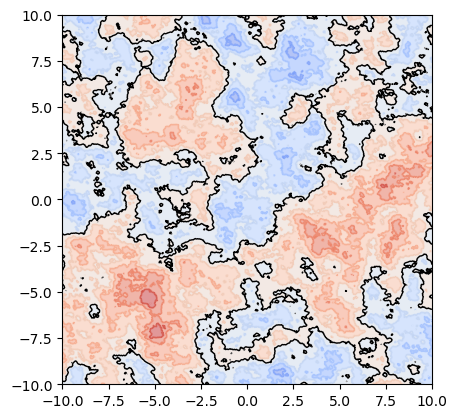

testing/weight-space/mat/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.250-v=1.000/spectral_density.bin


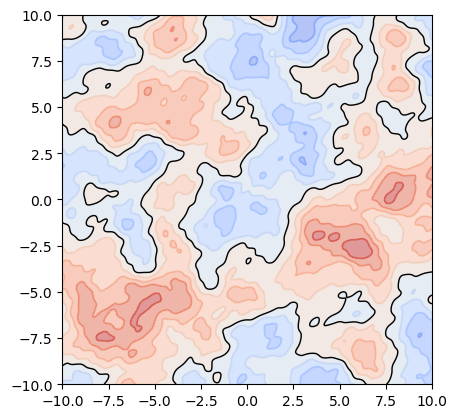

testing/weight-space/mat/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.250-v=1.500/spectral_density.bin


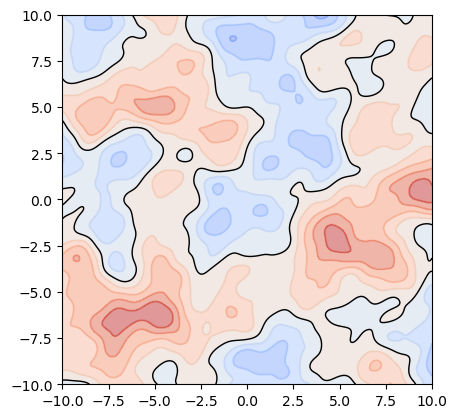

testing/weight-space/mat/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=0.250-v=2.500/spectral_density.bin


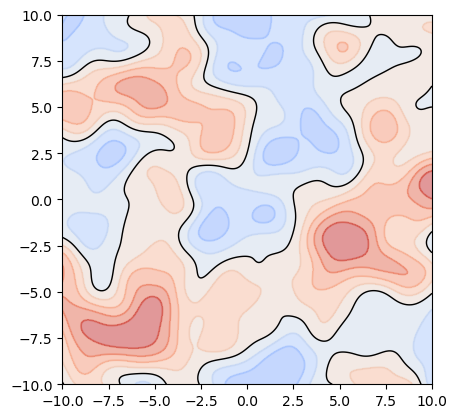

testing/weight-space/mat/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=1.000-v=1.500/spectral_density.bin


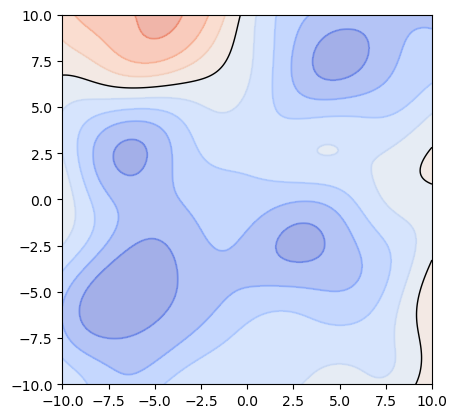

testing/weight-space/mat/aniso=[1.0000,1.0000,1.0000]-s=1.000-l=1.000-v=2.500/spectral_density.bin


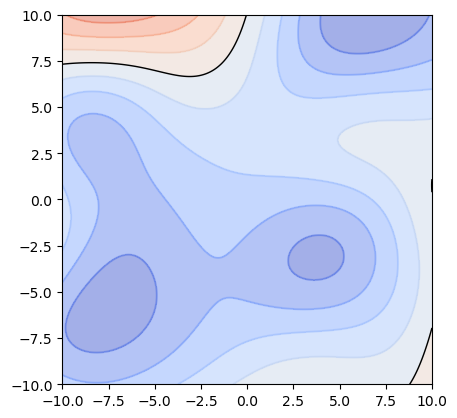

: 

In [17]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.stats
import scipy.special
import utils
import matplotlib.patches as patches

def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

for file in glob.glob("testing/weight-space/mat/*/spectral_density.bin"):
    file = file.replace("\\", "/")
    print(file)

    spectrum = np.reshape(np.fromfile(file, dtype=np.float64), (-1))
    samples = np.reshape(np.fromfile(file.replace("spectral_density.bin", "spectral_density_samples.bin"), dtype=np.float64), (-1))
    
    grid_xs = np.reshape(np.fromfile(file.replace("spectral_density.bin", "grid-coordinates.bin"), dtype=np.float64), (-1))
    real = np.reshape(np.fromfile(file.replace("spectral_density.bin", "grid-samples.bin"), dtype=np.float64), (grid_xs.shape[0],grid_xs.shape[0])).T
    ray_ps = [] # np.reshape(np.fromfile(file.replace("spectral_density.bin", "ray-points.bin"), dtype=np.float64), (-1,3))
    ray_ds = [] #np.reshape(np.fromfile(file.replace("spectral_density.bin", "ray-distances.bin"), dtype=np.float64), (-1))
    affine_interval_cs = [] #np.reshape(np.fromfile(file.replace("spectral_density.bin", "affine-interval-centers.bin"), dtype=np.float64), (-1,3))
    affine_interval_extends = [] # np.reshape(np.fromfile(file.replace("spectral_density.bin", "affine-interval-extends.bin"), dtype=np.float64), (-1,3))

    wos_ps = [] #np.reshape(np.fromfile(file.replace("spectral_density.bin", "wos-centers.bin"), dtype=np.float64), (-1,3))
    wos_ds = [] #np.reshape(np.fromfile(file.replace("spectral_density.bin", "wos-radii.bin"), dtype=np.float64), (-1))

    xs = grid_xs
    xx, yy = np.meshgrid(xs,xs)
    utils.plot_realization(real, plt.gca(), xx, yy,clw=1)


    #plt.scatter(ray_ps[:,0], ray_ps[:,1], s=10, c="grey")
    #plt.plot(ray_ps[:,0], ray_ps[:,1], c="grey")
    #circles(ray_ps[:,0], ray_ps[:,1], ray_ds, c="grey", facecolor=None, alpha=0.3, ls='--', zorder=10)
    
    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    kw = dict(arrowstyle=style, color="k")

    for i, c in enumerate(affine_interval_cs):
        ortho_extend = np.array([-affine_interval_extends[i,1], affine_interval_extends[i,0]]) / np.sqrt(np.sum(affine_interval_extends[i]**2))
        offset = 0
        p = plt.scatter(affine_interval_cs[i,0]+ i*offset*ortho_extend[0], affine_interval_cs[i,1]+ i*offset*ortho_extend[1], s=10, alpha=0.4)

        plt.plot(
            [affine_interval_cs[i,0] - affine_interval_extends[i,0] + i*offset*ortho_extend[0], affine_interval_cs[i,0] + affine_interval_extends[i,0] + i*offset*ortho_extend[0]], 
            [affine_interval_cs[i,1] - affine_interval_extends[i,1] + i*offset*ortho_extend[1], affine_interval_cs[i,1]+ affine_interval_extends[i,1] + i*offset*ortho_extend[1]],c=p.get_facecolor())

        # if(i < affine_interval_cs.shape[0]-1):
        #     plt.gca().add_patch(patches.FancyArrowPatch(affine_interval_cs[i,:2], affine_interval_cs[i+1,:2],
        #                      connectionstyle="arc3,rad=.4", **kw))

    #plt.gca().add_patch(patches.FancyArrowPatch(affine_interval_cs[0,:2]-affine_interval_extends[0,:2], affine_interval_cs[-1,:2], **kw))
    
    pref = -1
    if len(wos_ps) > 0:
        plt.scatter(wos_ps[0,0], wos_ps[0,1], c="green", linewidth=0.2, zorder=11)
        plt.scatter(wos_ps[-1,0], wos_ps[-1,1], c="red", linewidth=0.2, zorder=11)
        plt.plot(wos_ps[:pref,0], wos_ps[:pref,1], c="grey", linewidth=0.2)
        plt.scatter(wos_ps[:pref,0], wos_ps[:pref,1], c="grey", s=10, alpha=0.4)
        circles(wos_ps[:pref,0], wos_ps[:pref,1], wos_ds[:pref], c="grey", facecolor=None, alpha=0.2, ls='--', zorder=10)

    plt.xlim(np.min(grid_xs), np.max(grid_xs))
    plt.ylim(np.min(grid_xs), np.max(grid_xs))

    plt.savefig(file.replace("spectral_density.bin", "plot.pdf"), dpi=300)

    plt.show()

    #xs = np.linspace(0, 10, len(spectrum))
    #plt.ylim(0, 1.1)
    #plt.plot(xs, spectrum)
    #plt.hist(samples, range=(0,10), density=True, bins=100)

    plt.show()